In [32]:
# Basics Importation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# For Detailed Stats Output
import statsmodels.api as sm
# The linear regression models 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV
# Instantiating the linear regression models
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
# The tree model
from sklearn import tree
# Instantiating the tree model (regression type)
regressor = tree.DecisionTreeRegressor()
# The ensemble model for random forest and bagging
from sklearn import ensemble
# Instantiating the ensemble models
randomForest = ensemble.RandomForestRegressor()
bagging = ensemble.BaggingRegressor()
# Instantiating the boost models
gbm = ensemble.GradientBoostingRegressor()
abr = ensemble.AdaBoostRegressor()
# xg boost
import xgboost as xgb
# lg boost
import lightgbm as lgb
# K mean clustering
from sklearn.cluster import KMeans
kmeans = KMeans()
# The model selection for cross validation, k fold splits, train_test_split, grid search etc. 
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Some automatic feature selection functions (recursive finding, best feature selection etc.)
import sklearn.feature_selection as fs
# Importing the different error evaluation/metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score
# Importing PCA
from sklearn.decomposition import PCA
# Making it so that we can see all columns of the dataframe
pd.set_option('display.max_columns', None)

# Import data
df=pd.read_csv('standardized_with_outlier_dummified_df_total.csv', index_col='Id')
df_test=pd.read_csv('standardized_with_outlier_dummified_df_test.csv', index_col='Id')
x=df[~df.SalePrice.isnull()].drop(['SalePrice'],axis=1)
y=df[~df.SalePrice.isnull()].SalePrice
x_test=df_test
# df_test must have (1459) rows

### Functions

In [33]:
def undummify(dataframe):
    tot_col=dataframe.columns
    cat_col=list(tot_col[tot_col.str.contains('__')])
    cat_col_split=set(map(lambda x:x.split('__')[0],cat_col))
    cat_dict={}
    for col in cat_col_split:
        sub_df=dataframe[cat_col].loc[:,list(map(lambda x:col in x, dataframe[cat_col].columns))]
        for i in sub_df.columns:
            label_num=int(i.split('__')[1])
            sub_df.loc[:,i]=np.array(sub_df.loc[:,i])*label_num
        cat_dict[col]=sub_df.sum(axis=1)+1
    df1=dataframe.drop(cat_col,axis=1)
    df2=pd.DataFrame(cat_dict)
    return pd.concat([df1,df2],axis=1)

In [34]:
def important_coefs_lasso(model, dataframe):
    '''
    - A function that returns non-zero coefficients in order from a lasso model output
    ---------------
    - dataframe: dataframe of model inputs
    - model: model object
    '''
    lassoCoef = pd.Series(model.coef_, index=dataframe.columns)
    lassoCoef=lassoCoef[np.abs(lassoCoef)>0]
    return lassoCoef.sort_values(ascending=False)

In [35]:
def sort_ridge_coefs(model, dataframe):
    ridge_coef = pd.Series(model.coef_, index=dataframe.columns)
    ridge_coef.sort_values(ascending=False)
    order = abs(ridge_coef).sort_values(ascending=False)
    return ridge_coef[order.index]

### Create Train/Test Split

In [36]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)

### Lasso Model

#### *Grid Search for Optimal Alpha*

In [37]:
#define alpha range and train lasso model
alphaRange = np.linspace(10e-6,0.05,100)

grid_param=[{'alpha': alphaRange}]
para_search = GridSearchCV(estimator=Lasso(max_iter=5000),\
                           param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=5000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-05, 5.14949495e-04, 1.01989899e-03, 1.52484848e-03,
       2.02...
       4.04059596e-02, 4.09109091e-02, 4.14158586e-02, 4.19208081e-02,
       4.24257576e-02, 4.29307071e-02, 4.34356566e-02, 4.39406061e-02,
       4.44455556e-02, 4.49505051e-02, 4.54554545e-02, 4.59604040e-02,
       4.64653535e-02, 4.69703030e-02, 4.74752525e-02, 4.79802020e-02,
       4.84851515e-02, 4.89901010e-02, 4.94950505e-02, 5.00000000e-02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

#### *Visualize Grid Search Results*

Best Test MSE: 0.01678765155518167
Best Alpha: 0.000514949494949495


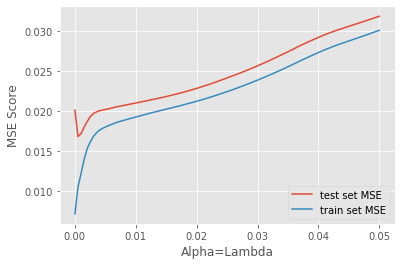

In [38]:
#plot cross validation results
plt.plot(alphaRange,-1*para_search.cv_results_['mean_test_score'], label=r'test set MSE')
plt.plot(alphaRange,-1*para_search.cv_results_['mean_train_score'], label=r'train set MSE')
plt.legend(loc=4)

plt.xlabel('Alpha=Lambda')
plt.ylabel('MSE Score')
lasso_best_score = para_search.best_score_
lasso_best_alpha = para_search.best_params_['alpha']
print('Best Test MSE: %s' %(abs(lasso_best_score)))
print('Best Alpha: %s' %(lasso_best_alpha))

#### *Lasso Results on Test Set*

In [39]:
lasso.set_params(alpha=lasso_best_alpha, normalize = False)
lasso.fit(trainX,trainY)
l_MSE = np.mean((lasso.predict(testX)-testY)**2)
l_RMSE_in_dollars = np.mean((np.exp(lasso.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(l_MSE))
print('Test RMSE in $$: %s' %(l_RMSE_in_dollars))

Test MSE: 0.0299077939775106
Test RMSE in $$: 95569.65720879455


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

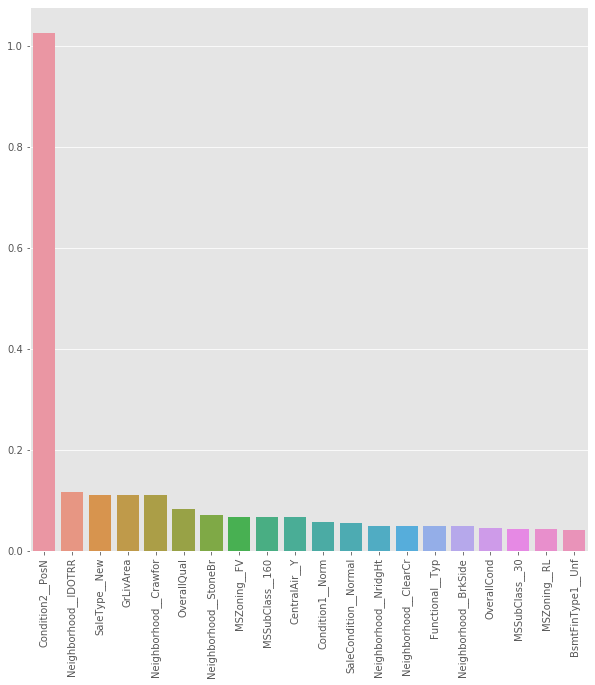

In [154]:
lasso_best_feat=important_coefs_lasso(lasso, trainX)
lasso_best_feat=abs(lasso_best_feat)
lasso_best_feat=lasso_best_feat.sort_values(ascending=False)
#visualize best predictors
plt.figure(figsize=(10,10))
sns.barplot(x=lasso_best_feat.index[0:20],y=abs(lasso_best_feat.values[0:20]))
plt.xticks(rotation=90)

### Ridge Model

#### *Grid Search for Optimal Alpha*

In [41]:
#define alpha range and train ridge model
r_alphaRange = np.linspace(10e-3,100,100)

r_grid_param=[{'alpha': r_alphaRange}]
r_para_search = GridSearchCV(estimator=Ridge(max_iter=5000),\
                           param_grid=r_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
r_para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=5000, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01...
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

#### *Visualize Grid Search Results*

Best Test MSE: 0.0173957058678154
Best Alpha: 12.13


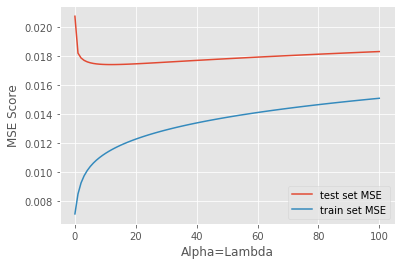

In [42]:
#plot cross validation results
plt.plot(r_alphaRange,-1*r_para_search.cv_results_['mean_test_score'], label=r'test set MSE')
plt.plot(r_alphaRange,-1*r_para_search.cv_results_['mean_train_score'], label=r'train set MSE')
plt.legend(loc=4)

plt.xlabel('Alpha=Lambda')
plt.ylabel('MSE Score')
ridge_best_score = r_para_search.best_score_
ridge_best_alpha = r_para_search.best_params_['alpha']
print('Best Test MSE: %s' %(abs(ridge_best_score)))
print('Best Alpha: %s' %(ridge_best_alpha))

#### *Ridge Results on Test Set*

In [43]:
ridge.set_params(alpha=ridge_best_alpha, normalize = False)
ridge.fit(trainX,trainY)
r_MSE = np.mean((ridge.predict(testX)-testY)**2)
r_RMSE_in_dollars = np.mean((np.exp(ridge.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(r_MSE))
print('Test RMSE in $$: %s' %(r_RMSE_in_dollars))

Test MSE: 0.025502002333961635
Test RMSE in $$: 77008.2327668456


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

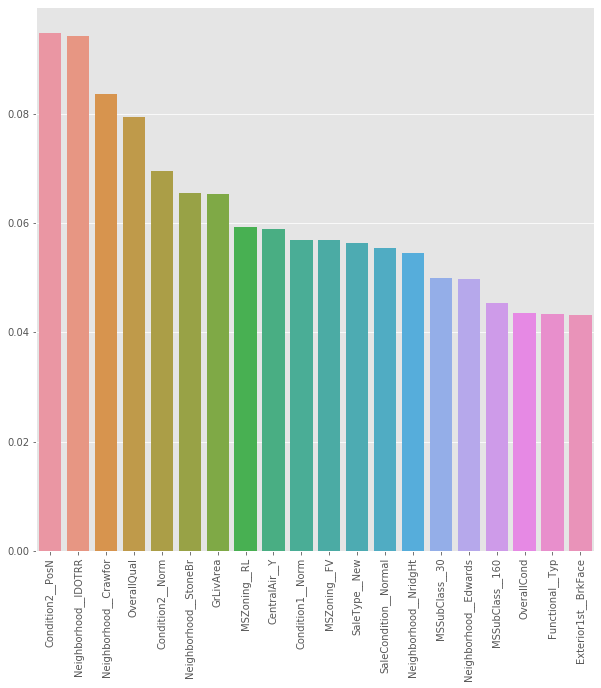

In [153]:
#visualize best predictors
ridge_best_feat=sort_ridge_coefs(ridge, trainX)
plt.figure(figsize=(10,10))
sns.barplot(x=ridge_best_feat.index[0:20],y=abs(ridge_best_feat.values[0:20]))
plt.xticks(rotation=90)

### Elastic Net Model

#### *Grid Search for Optimal Alpha*

In [45]:
#define alpha range and train elastic net model
alphaSize = 100
rhoSize = 10
e_alphaRange = np.linspace(10e-4, 20, alphaSize)
l1_ratio = np.linspace(0.1, 1, rhoSize)

e_grid_param=[{'alpha': e_alphaRange, 'l1_ratio': l1_ratio}]
e_para_search = GridSearchCV(estimator=ElasticNet(max_iter=2000),\
                           param_grid=e_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
e_para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=2000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-03, 2.03010101e-01, 4.05020202e-01, 6...
       1.69698485e+01, 1.71718586e+01, 1.73738687e+01, 1.75758788e+01,
       1.77778889e+01, 1.79798990e+01, 1.81819091e+01, 1.83839192e+01,
       1.85859293e+01, 1.87879394e+01, 1.89899495e+01, 1.91919596e+01,
       1.93939697e+01, 1.95959798e+01, 1.97979899e+01, 2.00000000e+01]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

#### *Output eNet Params*

In [46]:
e_best_alpha = e_para_search.best_params_['alpha']
e_best_l1ratio = list(e_para_search.best_params_.values())[1]
e_best_score = e_para_search.best_score_
print('Best Test MSE: %s' %(abs(e_best_score)))
print('Best Alpha: %s' %(e_best_alpha))
print('Best Rho: %s' %(e_best_l1ratio))

Best Test MSE: 0.01690531947632338
Best Alpha: 0.001
Best Rho: 0.6


#### *eNet Results on Test Set*

In [47]:
elasticnet.set_params(alpha=e_best_alpha, l1_ratio = e_best_l1ratio, normalize = False)
elasticnet.fit(trainX,trainY)
e_MSE = np.mean((elasticnet.predict(testX)-testY)**2)
e_RMSE_in_dollars = np.mean((np.exp(elasticnet.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(e_MSE))
print('Test RMSE in $$: %s' %(e_RMSE_in_dollars))

Test MSE: 0.02759794516115223
Test RMSE in $$: 87893.1187668082


In [48]:
sort_ridge_coefs(elasticnet, trainX)

Condition2__PosN        -0.593309
Neighborhood__IDOTRR    -0.108461
Neighborhood__Crawfor    0.105787
GrLivArea                0.103396
SaleType__New            0.103043
                           ...   
Exterior2nd__Stone       0.000000
Exterior2nd__Plywood     0.000000
Exterior2nd__Other      -0.000000
Exterior2nd__ImStucc     0.000000
Exterior1st__CBlock     -0.000000
Length: 234, dtype: float64

#### *Visualize Grid Search Results*

In [49]:
# TAKES A WHILE TO RUN!!!
# Manual Grid Search for Elastic Net
N_alpha = 500
N_rho   = 50
alphaRange = np.linspace(0.001, 1.5, N_alpha)
rhoRange   = np.linspace(0.001, 1, N_rho) # we avoid very small rho by starting at 0.1
scores     = np.zeros((N_alpha, N_rho))
trainR2    = np.zeros((N_alpha, N_rho))
testR2     = np.zeros((N_alpha, N_rho))
intercepts = np.zeros((N_alpha, N_rho))
coefs      = np.zeros((N_alpha, N_rho, trainX.shape[1]))
for alphaIdx, alpha in enumerate(alphaRange):
    print(alphaIdx,'/',N_alpha,end='\r')
    for rhoIdx, rho in enumerate(rhoRange):
            elasticnet.set_params(alpha=alpha, l1_ratio=rho)
            elasticnet.fit(trainX,trainY)
            trainR2[alphaIdx,rhoIdx] = elasticnet.score(trainX,trainY)  
            testR2[alphaIdx,rhoIdx] = elasticnet.score(testX,testY)   
            intercepts[alphaIdx, rhoIdx] = elasticnet.intercept_
            coefs[alphaIdx, rhoIdx, :] = elasticnet.coef_
trainR2_scores=np.array(trainR2)
testR2_scores=np.array(testR2)
optimal_train_index=np.where(trainR2_scores == np.max(trainR2_scores))
optimal_test_index=np.where(testR2_scores == np.max(testR2_scores))

optimal_train_alpha=alphaRange[optimal_train_index[0]]
optimal_train_rho=rhoRange[optimal_train_index[1]]
optimal_test_alpha=alphaRange[optimal_test_index[0]]
optimal_test_rho=rhoRange[optimal_test_index[1]]

Text(0, 0.5, 'Alpha = Lambda')

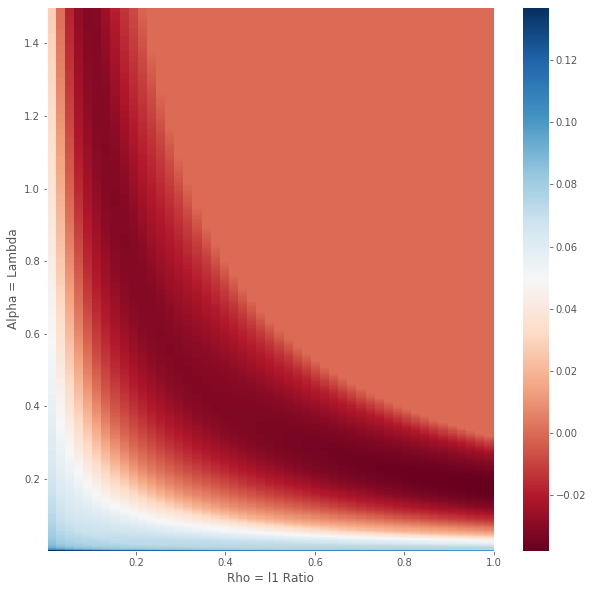

In [57]:
# Visualizing the elastic net R^2_train_score-R^2_test_score
# minimum is best value for alph and rho

fig = plt.figure(figsize=(10,10))
xplot = rhoRange  # alpha was originally in rows. see pcolor documentation
yplot = alphaRange   # alpha was originally in rows. see pcolor documentation
Xplot, Yplot = np.meshgrid(xplot, yplot) # alpha was originally in rows. see pcolor documentation
Zplot = trainR2_scores-testR2_scores  # alpha was originally in rows. see pcolor documentation
# Z = np.flipud(np.fliplr((trainR2_scores-testR2_scores).T))# alpha was originally in rows. see pcolor documentation
plt.pcolor(Xplot,Yplot,Zplot,cmap='RdBu')
# plt.axis([xplot.min(), xplot.max(), yplot.min(), yplot.max()])
plt.colorbar()
plt.xlabel('Rho = l1 Ratio')
plt.ylabel('Alpha = Lambda')

### CV Bagging

In [95]:
# Use double underscore to indicate this parameter "belongs":
# base_estimator__ <-- belongs to base_estimator (use __)
# Other parameters without __ (double underscore) are parameters for the bagging classifier

# TAKES TOO LONG TO RUN PARAM_GRID2
# param_grid2 = {
#     'base_estimator__min_samples_leaf' : range(2, 13),\
#     'base_estimator__min_samples_split': range(2, 21),\
#     'n_estimators' : range(100,600,100),\
#     'max_samples' : [0.3, 0.6, 0.9],\
#     'max_features': [0.25,0.5,0.75]
# }
param_grid = {
    'max_samples' : np.linspace(0.1,0.9,18),\
    'max_features': np.linspace(0.1,0.9,18)
}
grid_search_bag = GridSearchCV(ensemble.BaggingRegressor(base_estimator=tree.DecisionTreeRegressor(criterion="mse",splitter="best",min_samples_leaf=2,min_samples_split=15),\
                                                         n_estimators=100,bootstrap=True,oob_score = True,n_jobs=-1,random_state=0),\
                               param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
%time grid_search_bag.fit(trainX, trainY)

# Print results    
print('Best parameters: {}'.format(grid_search_bag.best_params_))
print('Best MSE Score: {0:.3f}'.format(-grid_search_bag.best_score_)) # NOTE: it is negated! (Sklearn convention)
print('MSE Score on training data set (using best parameters): {0:.6f}'.format(-grid_search_bag.score(trainX, trainY)))
print('MSE Score on test data set (using best parameters): {0:.6f}'.format(-grid_search_bag.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_bag.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 12.6 s, sys: 598 ms, total: 13.2 s
Wall time: 4min 56s
Best parameters: {'max_features': 0.4764705882352941, 'max_samples': 0.9}
Best MSE Score: 0.022
MSE Score on training data set (using best parameters): 0.010448
MSE Score on test data set (using best parameters): 0.017619
RMSE in $$ on test data set (using best parameters): 33444.5


#### *Visualize Grid Search Results*

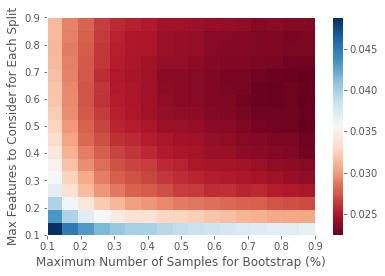

In [96]:
xplot=list(param_grid['max_samples'])
yplot=list(param_grid['max_features'])
zplot=-1*grid_search_bag.cv_results_['mean_test_score'].reshape(len(yplot),-1) # NOTE: it is negated! (Sklearn convention)
plt.pcolor(xplot,yplot,zplot,cmap='RdBu')
plt.colorbar();
plt.xlabel('Maximum Number of Samples for Bootstrap (%)');
plt.ylabel('Max Features to Consider for Each Split');

#### *Visualize MSE*

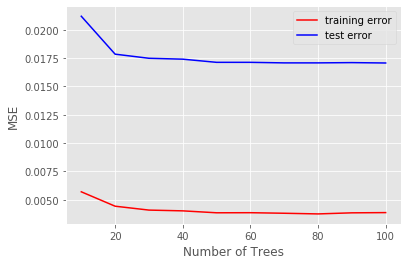

In [97]:
number_estimators = range(10, 110,10)
train_error = []
test_error = []
for i in number_estimators:
    bagging.set_params(n_estimators=i,bootstrap=True,oob_score = False,n_jobs=-1,random_state=0,\
                       max_samples=grid_search_bag.best_params_['max_samples'],max_features=grid_search_bag.best_params_['max_features'])
    bagging.fit(trainX, trainY)
    train_error.append(metrics.mean_squared_error(trainY, bagging.predict(trainX))) 
    test_error.append(metrics.mean_squared_error(testY, bagging.predict(testX))) 
import matplotlib.pyplot as plt
plt.plot(number_estimators, train_error, c='red', label='training error')
plt.plot(number_estimators, test_error, c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()

### Random Forests

In [98]:
param_grid = {
    'max_depth' : range(5,20),\
    'max_features': range(5,20)
}
randomForest = ensemble.RandomForestRegressor()
grid_search_forest = GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
                                                                 min_samples_leaf=2,min_samples_split=2,\
                                                                 bootstrap=True,oob_score = True,n_jobs=-1),\
                                  param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
%time grid_search_forest.fit(trainX, trainY)

# Print results    
print('Best parameters: {}'.format(grid_search_forest.best_params_))
print('Best MSE Score: {0:.3f}'.format(-grid_search_forest.best_score_)) # NOTE: it is negated! (Sklearn convention)
print('MSE Score on training data set (using best parameters): {0:.3f}'.format(-grid_search_forest.score(trainX, trainY)))
print('MSE Score on test data set (using best parameters): {0:.3f}'.format(-grid_search_forest.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_forest.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 8.16 s, sys: 342 ms, total: 8.5 s
Wall time: 1min 44s
Best parameters: {'max_depth': 17, 'max_features': 17}
Best MSE Score: 0.023
MSE Score on training data set (using best parameters): 0.008
MSE Score on test data set (using best parameters): 0.018
RMSE in $$ on test data set (using best parameters): 34286.8


#### *Visualize Grid Search Results*

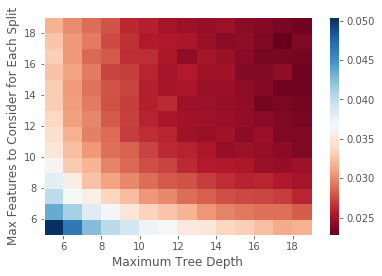

In [99]:
xplot=list(param_grid['max_depth'])
yplot=list(param_grid['max_features'])
zplot=-1*grid_search_forest.cv_results_['mean_test_score'].reshape(len(yplot),-1) # NOTE: it is negated! (Sklearn convention)
plt.pcolor(xplot,yplot,zplot,cmap='RdBu')
plt.colorbar();
plt.xlabel('Maximum Tree Depth');
plt.ylabel('Max Features to Consider for Each Split');

#### *Visualize MSE*

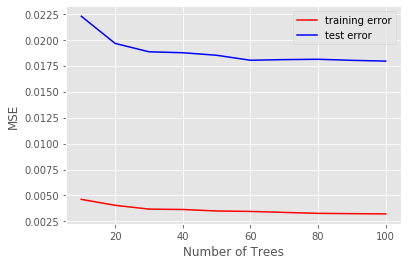

In [100]:
number_estimators = range(10,110,10)
train_error = []
test_error = []
for i in number_estimators:
    randomForest.set_params(n_estimators=i,criterion="mse",bootstrap=True,oob_score = False,n_jobs=-1,random_state=0,\
                       max_depth=grid_search_forest.best_params_['max_depth'],max_features=grid_search_forest.best_params_['max_features'])
    randomForest.fit(trainX, trainY)
    train_error.append(metrics.mean_squared_error(trainY, randomForest.predict(trainX))) 
    test_error.append(metrics.mean_squared_error(testY, randomForest.predict(testX))) 
import matplotlib.pyplot as plt
plt.plot(number_estimators, train_error, c='red', label='training error')
plt.plot(number_estimators, test_error, c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

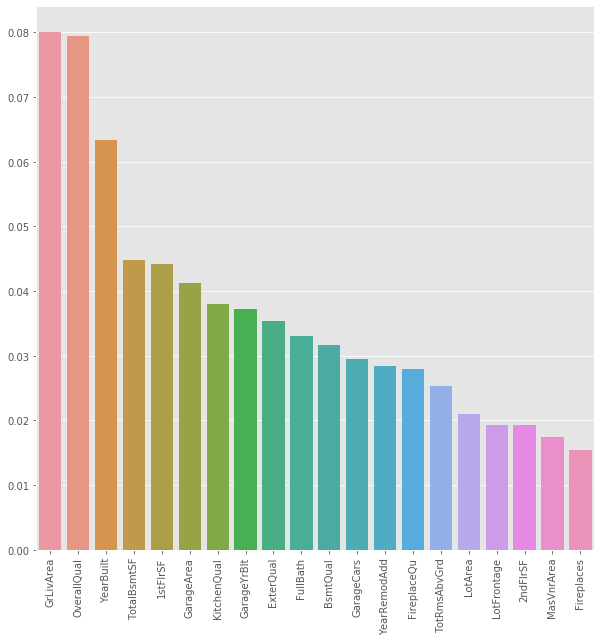

In [101]:
#visualize best predictors
feature_importance=pd.Series(randomForest.feature_importances_,index=trainX.columns)
feature_importance.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(10,10))
sns.barplot(x=feature_importance.index[0:20],y=feature_importance.values[0:20])
plt.xticks(rotation=90)

### Gradient Boost

In [134]:
boost_param_grid = {'learning_rate': np.linspace(0.05,0.3,6), 'max_depth': range(3,8),'min_samples_split': range(2,8)}
grid_search_boost = GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100,max_features='sqrt',min_samples_leaf=5,random_state=0), param_grid = boost_param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
%time grid_search_boost.fit(trainX, trainY)

# Print results    
print('Best parameters: {}'.format(grid_search_boost.best_params_))
print('Best MSE Score: {0:.3f}'.format(-grid_search_boost.best_score_)) # NOTE: it is negated! (Sklearn convention)
print('MSE Score on training data set (using best parameters): {0:.3f}'.format(-grid_search_boost.score(trainX, trainY)))
print('MSE Score on test data set (using best parameters): {0:.3f}'.format(-grid_search_boost.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_boost.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 6.8 s, sys: 362 ms, total: 7.16 s
Wall time: 50.4 s
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 2}
Best MSE Score: 0.019
MSE Score on training data set (using best parameters): 0.004
MSE Score on test data set (using best parameters): 0.015
RMSE in $$ on test data set (using best parameters): 28794.0


#### *Visualize MSE*

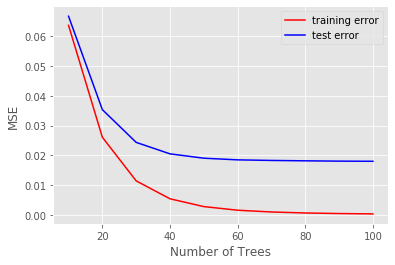

In [149]:
number_estimators = range(10,110,10)
train_error = []
test_error = []
for i in number_estimators:
    gbm.set_params(n_estimators=i,learning_rate=grid_search_boost.best_params_['learning_rate'],criterion="mse",random_state=0,\
                       max_depth=grid_search_boost.best_params_['max_depth'],min_samples_split=grid_search_boost.best_params_['min_samples_split'])
    gbm.fit(trainX, trainY)
    train_error.append(metrics.mean_squared_error(trainY, gbm.predict(trainX))) 
    test_error.append(metrics.mean_squared_error(testY, gbm.predict(testX))) 
import matplotlib.pyplot as plt
plt.plot(number_estimators, train_error, c='red', label='training error')
plt.plot(number_estimators, test_error, c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

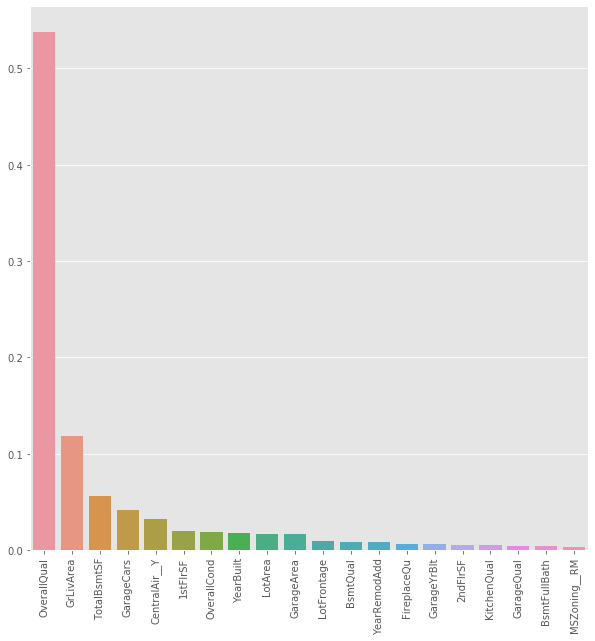

In [150]:
#visualize best predictors
gbm_feature_importance=pd.Series(gbm.feature_importances_,index=trainX.columns)
gbm_feature_importance.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(10,10))
sns.barplot(x=gbm_feature_importance.index[0:20],y=gbm_feature_importance.values[0:20])
plt.xticks(rotation=90)

### Store Outputs

In [ ]:
# index = ['Lasso', 'Ridge', 'eNet', 'Bagged_Tree', 'Rand_Forests']
# scores = [l_MSE, r_MSE, e_MSE, -grid_search_bag.score(testX, testY), -grid_search_forest.score(testX, testY)]
# model_results = pd.DataFrame(data=scores,index=index, columns = ['basic5'])

In [ ]:
# fill in name of dataframe
# model_results['?'] = [l_MSE, r_MSE, e_MSE, -grid_search_bag.score(testX, testY), -grid_search_forest.score(testX, testY)]

In [ ]:
np.exp(para_search.predict(x_test))

In [ ]:
np.exp(lasso.predict(x_test))

In [ ]:
x_test.index

In [ ]:
submission = pd.DataFrame()
submission['Id'] = x_test.index
submission['SalePrice'] = np.exp(lasso.predict(x_test))
submission.to_csv('AAAG.csv',index=False)
